## practice of dicom control

 - URL : https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/

### load data

In [1]:
from glob import glob

data_path = 'C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data'
output_path = working_path = '01_export_data/'
g = glob(data_path + '/*.dcm')

# Print out the first 5 file names to verify we're in the right folder.
print("Total of %d DICOM images.\nFirst 5 filenames:" % len(g))
print('\n'.join(g[:5]))

Total of 397 DICOM images.
First 5 filenames:
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_003.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_004.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_005.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_006.dcm
C:/Users/dDk13/Desktop/ddk_test/PointCloudTest/data/manekin_data\CT_007.dcm


### helper func.

In [2]:
import numpy as np
import dicom
import os

#      
# Loop over the image files and store everything into a list.
# 

def load_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

id=0
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)

c:\users\ddk13\appdata\local\programs\python\python36\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [6]:
np.save(output_path + "fullimages_%d.npy" % (id), imgs)

### Displaying Images

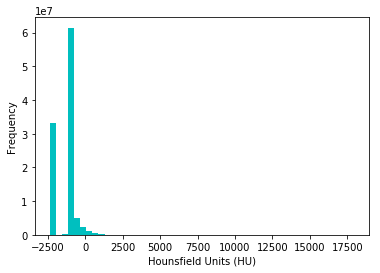

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

file_used=output_path+"fullimages_%d.npy" % id
imgs_to_process = np.load(file_used).astype(np.float64) 

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

### Critiquing the Histogram

| Substance | Houndsfeld Units |
|---|---|
| `Air` | −1000 |
| `Lung` | −500 |
| `Fat` | −100 to −50 |
| `Water` | 0 |
| `Blood` | +30 to +70 |
| `Muscle` | +10 to +40 |
| `Liver` | +40 to +60 |
| `Bone` | +700 (cancellous bone) to +3000 (cortical bone) |

### Displaying an Image Stack

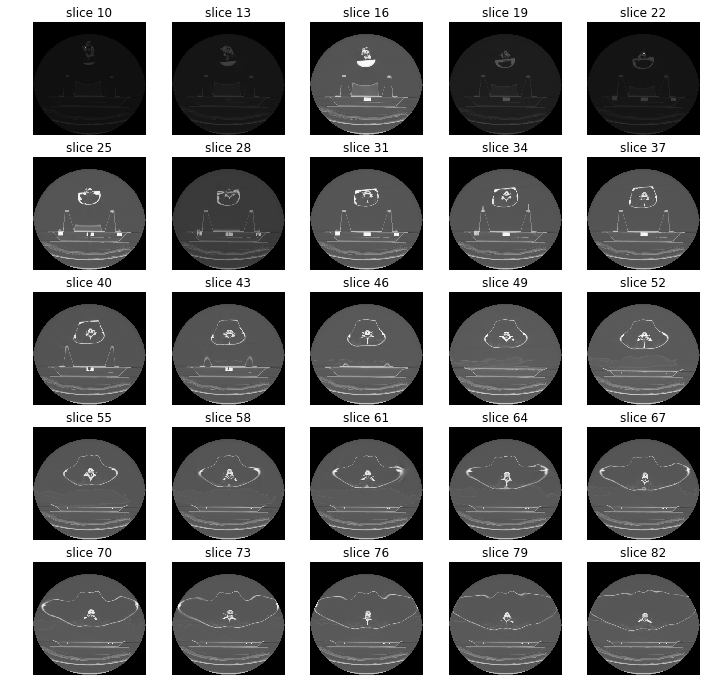

In [8]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=5, cols=5, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [19]:
type(imgs_to_process[188])

numpy.ndarray

### boundary detection : canny

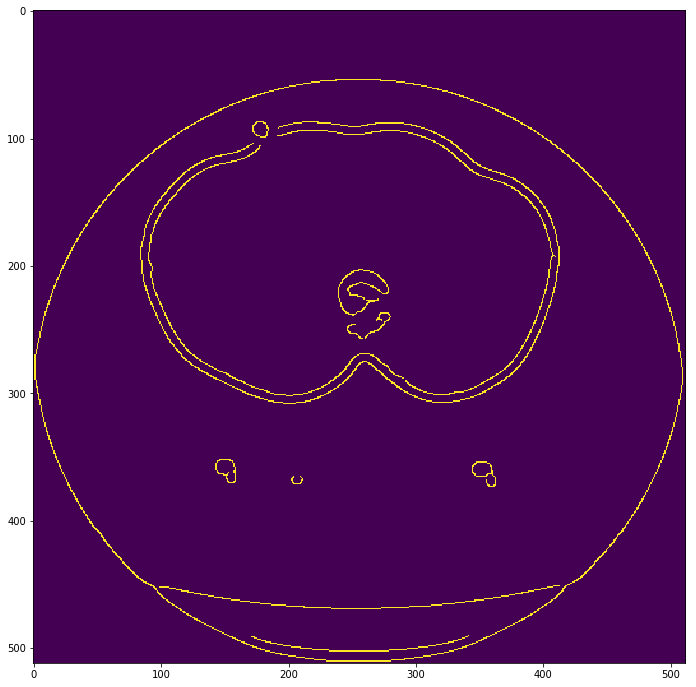

In [72]:
from skimage import feature

img = imgs_to_process[188]

edges = feature.canny(
    image=img,
    sigma=3,
    low_threshold=-1000,
    high_threshold=1000,
    
)

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(edges)
plt.show()

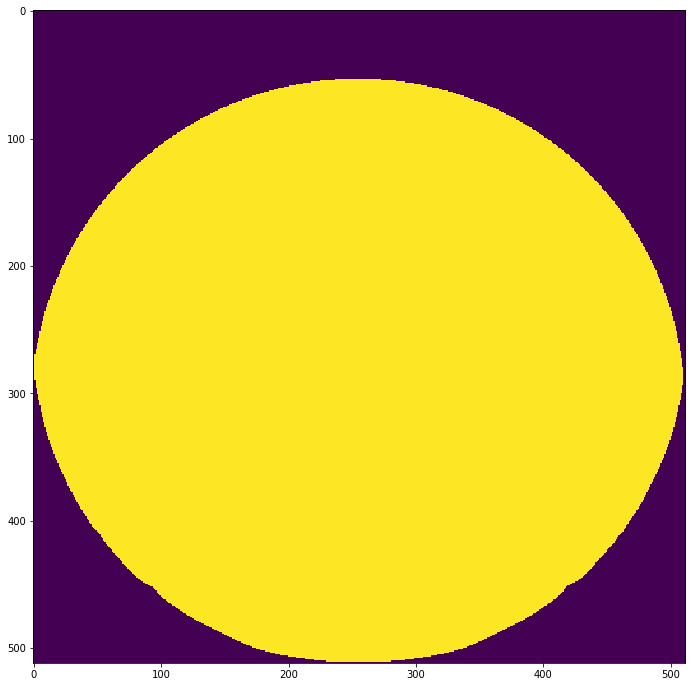

In [73]:
from scipy import ndimage as ndi
fill_abdomen = ndi.binary_fill_holes(edges)

fig,ax = plt.subplots(1,1,figsize=[12,12])
ax.imshow(fill_abdomen)
plt.show()

### Resampling

In [9]:
print("Slice Thickness: %f" % patient[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (patient[0].PixelSpacing[0], patient[0].PixelSpacing[1]))

Slice Thickness: 2.000000
Pixel Spacing (row, col): (0.976000, 0.976000) 


In [10]:
import scipy.ndimage

id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

print("Shape before resampling\t", imgs_to_process.shape)
imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
print("Shape after resampling\t", imgs_after_resamp.shape)

Shape before resampling	 (397, 512, 512)
Shape after resampling	 (794, 500, 500)


### 3D Plotting

In [11]:
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *

def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_facecolor((0.7, 0.7, 0.7))
    plt.show()

Transposing surface
Calculating surface
Drawing


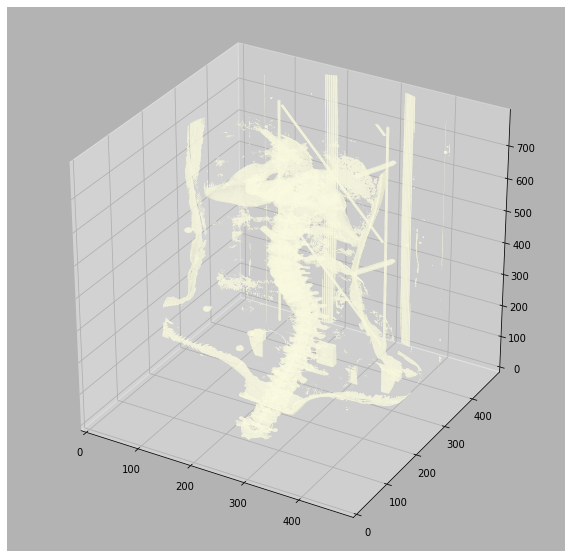

In [12]:
v, f = make_mesh(imgs_after_resamp, 350)
plt_3d(v, f)

In [14]:
^
v_, f_ = make_mesh(imgs_after_resamp, 350, 2)
plotly_3d(v_, f_)

SyntaxError: invalid syntax (<ipython-input-14-cd6615f3a15e>, line 1)

### Segmentation

In [ ]:
#Standardize the pixel values
def make_mask_of_surface(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[12, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(mask*img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return mask*img